<a href="https://colab.research.google.com/github/Likhithatugiti/CODSOFT/blob/main/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
import cvxpy as cp

In [3]:
def phi(x):
    x1, x2, x3, x4 = x
    return np.array([
        1,
        x1, x2, x3, x4,
        x1**2, x2**2, x3**2, x4**2,
        x1*x2, x1*x3, x1*x4,
        x2*x3, x2*x4,
        x3*x4
    ])

def build_design_matrix(X):
    return np.array([phi(x) for x in X])

In [4]:
np.random.seed(1)

N = 100
X = np.random.randn(N, 4)

Phi = build_design_matrix(X)
K = Phi.shape[1]

w_true = np.random.randn(K)
noise = 0.05 * np.random.randn(N)

y = Phi @ w_true + noise

In [5]:
def cost(Phi, y, w):
    r = Phi @ w - y
    return np.dot(r, r)

def grad(Phi, y, w):
    return 2 * Phi.T @ (Phi @ w - y)

In [19]:
w_var = cp.Variable(K)
prob = cp.Problem(cp.Minimize(cp.sum_squares(Phi @ w_var - y)))
prob.solve()

w_star = w_var.value
print("w* = ", w_star)
print("cost(w*) = ", cost(Phi, y, w_star))
print("gradient(w*) = ", grad(Phi, y, w_star))

w* =  [-1.30851673  0.07787357  0.37182956  1.2288808  -0.42528053  0.08277713
 -2.14250426 -0.8257599   0.45331136  1.09769987 -0.28011954  2.05102389
  1.76561752 -0.06685306 -2.41007839]
cost(w*) =  0.22220445007462827
gradient(w*) =  [-1.33226763e-15  6.42541576e-15 -2.22113994e-14  2.86159985e-14
  1.27814426e-14  3.27238237e-14 -8.86651863e-14 -4.40480985e-14
  2.22044605e-15 -4.77395901e-14  1.86378690e-14  1.44051437e-14
 -2.28432724e-14 -5.84671200e-14 -8.70874553e-15]


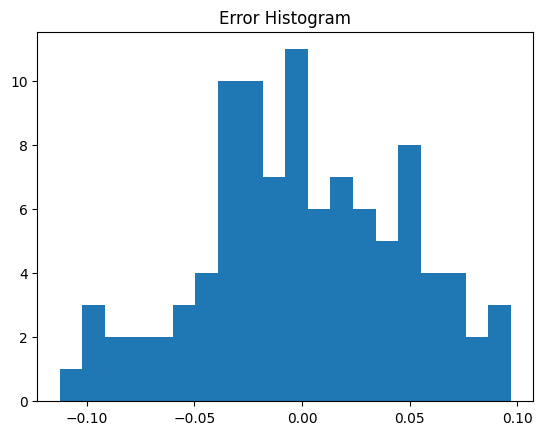

In [7]:
errors = y - Phi @ w_star

plt.hist(errors, bins=20)
plt.title("Error Histogram")
plt.show()

In [9]:
def gradient_descent(Phi,y,w0,eta,T):
    w = w0.copy()
    hist = []
    ws = []

    for _ in range(T):
        hist.append(cost(Phi,y,w))
        ws.append(w.copy())
        w -= eta * grad(Phi,y,w)

    return w, hist, ws

In [10]:
def accelerated_gd(Phi,y,w0,eta,T):
    w = w0.copy()
    z = w0.copy()
    t = 1
    hist = []
    ws = []

    for _ in range(T):
        hist.append(cost(Phi,y,w))
        ws.append(w.copy())

        w_old = w.copy()
        w = z - eta * grad(Phi,y,z)

        t_new = (1 + np.sqrt(1 + 4*t*t)) / 2
        z = w + ((t-1)/t_new)*(w - w_old)
        t = t_new

    return w, hist, ws

In [11]:
def sgd(Phi,y,w0,eta,T):
    w = w0.copy()
    hist = []
    ws = []
    N = len(y)

    for _ in range(T):
        hist.append(cost(Phi,y,w))
        ws.append(w.copy())

        i = np.random.randint(N)
        g = 2 * Phi[i] * (Phi[i] @ w - y[i])
        w -= eta * g

    return w, hist, ws

In [12]:
T = 1000
w0 = np.zeros(K)

w_gd, h_gd, ws_gd = gradient_descent(Phi,y,w0,1e-4,T)
w_agd, h_agd, ws_agd = accelerated_gd(Phi,y,w0,1e-4,T)
w_sgd, h_sgd, ws_sgd = sgd(Phi,y,w0,1e-3,T)

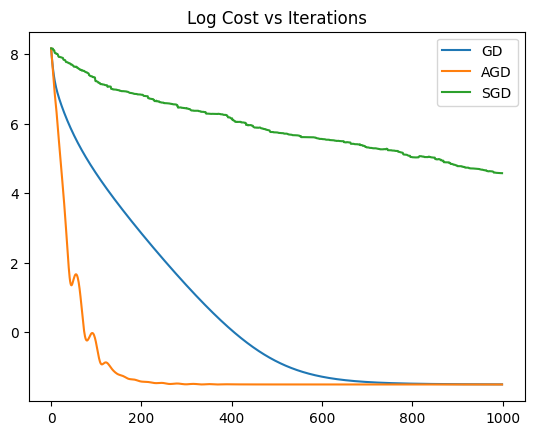

In [13]:
plt.plot(np.log(h_gd), label="GD")
plt.plot(np.log(h_agd), label="AGD")
plt.plot(np.log(h_sgd), label="SGD")
plt.legend()
plt.title("Log Cost vs Iterations")
plt.show()

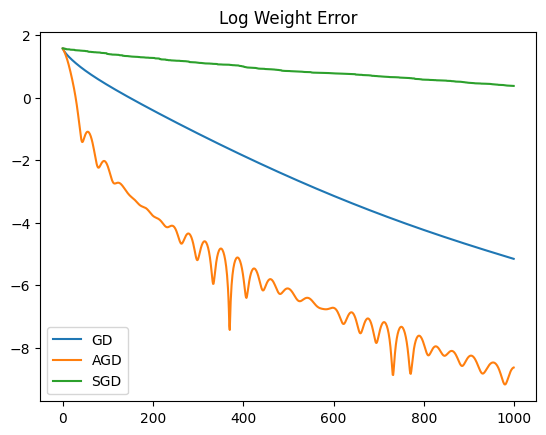

In [14]:
def weight_errors(ws):
    return [np.linalg.norm(w - w_star) for w in ws]

plt.plot(np.log(weight_errors(ws_gd)), label="GD")
plt.plot(np.log(weight_errors(ws_agd)), label="AGD")
plt.plot(np.log(weight_errors(ws_sgd)), label="SGD")
plt.legend()
plt.title("Log Weight Error")
plt.show()

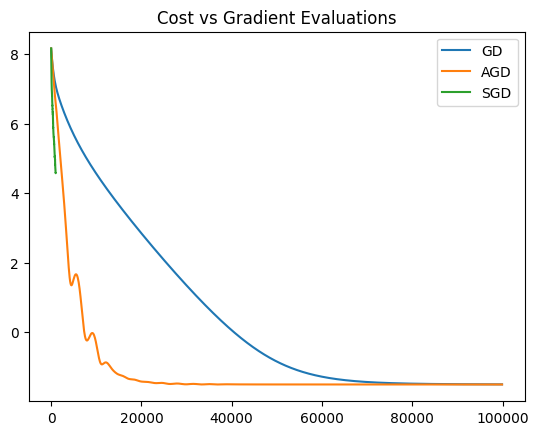

In [15]:
grad_eval_gd = np.arange(T) * N
grad_eval_sgd = np.arange(T)

plt.plot(grad_eval_gd, np.log(h_gd), label="GD")
plt.plot(grad_eval_gd, np.log(h_agd), label="AGD")
plt.plot(grad_eval_sgd, np.log(h_sgd), label="SGD")
plt.legend()
plt.title("Cost vs Gradient Evaluations")
plt.show()

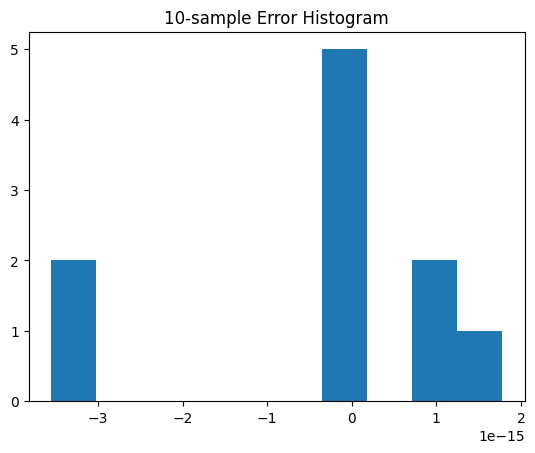

In [16]:
Phi10 = Phi[:10]
y10 = y[:10]

w = cp.Variable(K)
cp.Problem(cp.Minimize(cp.sum_squares(Phi10 @ w - y10))).solve()
w10 = w.value

err10 = y10 - Phi10 @ w10
plt.hist(err10)
plt.title("10-sample Error Histogram")
plt.show()

In [17]:
lam = 0.1

w = cp.Variable(K)
obj = cp.Minimize(cp.sum_squares(Phi @ w - y) + lam * cp.norm1(w))
cp.Problem(obj).solve()

w_reg = w.value

In [18]:
print("Nonzeros normal:", np.sum(np.abs(w_star) > 1e-6))
print("Nonzeros L1:", np.sum(np.abs(w_reg) > 1e-6))

Nonzeros normal: 15
Nonzeros L1: 15
